In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# ===============================
# 1. LOAD PREPROCESSED DATA
# ===============================

In [4]:
# Load selected features and target
X_selected = pd.read_csv('../Data/X_selected_features.csv')
y = pd.read_csv('../Data/y_target.csv').squeeze()
    
print(f" Loaded selected features: {X_selected.shape}")
print(f" Loaded target variable: {y.shape}")
print(f" Selected features: {list(X_selected.columns)}")
print(f" Target distribution: {y.value_counts().to_dict()}")

 Loaded selected features: (303, 10)
 Loaded target variable: (303,)
 Selected features: ['PC1', 'PC2', 'PC4', 'PC9', 'PC5', 'PC6', 'PC7', 'PC3', 'PC8', 'PC10']
 Target distribution: {0: 164, 1: 139}


# ===============================
# 2. K-MEANS CLUSTERING ANALYSIS
# ===============================

In [7]:
# Elbow Method to determine optimal K
print(" Applying Elbow Method to determine optimal K")

K_range = range(1, 11)
inertias = []
silhouette_scores = []
calinski_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_selected)
    inertias.append(kmeans.inertia_)
    
    if k > 1:  # Silhouette score needs at least 2 clusters
        sil_score = silhouette_score(X_selected, kmeans.labels_)
        cal_score = calinski_harabasz_score(X_selected, kmeans.labels_)
        silhouette_scores.append(sil_score)
        calinski_scores.append(cal_score)
    else:
        silhouette_scores.append(0)
        calinski_scores.append(0)

print(f" Computed clustering metrics for K from {K_range[0]} to {K_range[-1]}")

# Determine optimal K using different methods
# Method 1: Elbow method (manual inspection)
# Method 2: Maximum silhouette score
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]

# Method 3: Maximum Calinski-Harabasz score  
optimal_k_calinski = K_range[np.argmax(calinski_scores)]

print(f" Optimal K by Silhouette Score: {optimal_k_silhouette}")
print(f" Optimal K by Calinski-Harabasz Score: {optimal_k_calinski}")

# Use K=2 for binary problem comparison
optimal_k = 2
print(f" Selected K for analysis: {optimal_k} (binary problem)")

 Applying Elbow Method to determine optimal K
 Computed clustering metrics for K from 1 to 10
 Optimal K by Silhouette Score: 2
 Optimal K by Calinski-Harabasz Score: 2
 Selected K for analysis: 2 (binary problem)


# ===============================
# 3. APPLY K-MEANS WITH OPTIMAL K
# ===============================

In [8]:
# Apply K-means clustering
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(X_selected)

# Calculate clustering metrics
silhouette_avg = silhouette_score(X_selected, cluster_labels)
calinski_score = calinski_harabasz_score(X_selected, cluster_labels)
ari_score = adjusted_rand_score(y, cluster_labels)

print(f" K-Means clustering applied with K={optimal_k}")
print(f" Silhouette Score: {silhouette_avg:.4f}")
print(f" Calinski-Harabasz Score: {calinski_score:.4f}")
print(f" Adjusted Rand Index (vs true labels): {ari_score:.4f}")

# Cluster distribution
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f" Cluster distribution: {cluster_distribution}")

 K-Means clustering applied with K=2
 Silhouette Score: 0.1923
 Calinski-Harabasz Score: 70.6027
 Adjusted Rand Index (vs true labels): 0.4469
 Cluster distribution: {np.int32(0): np.int64(115), np.int32(1): np.int64(188)}


# ===============================
# 4. HIERARCHICAL CLUSTERING
# ===============================

In [9]:
# Different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
hierarchical_results = {}

for method in linkage_methods:
    print(f"   Applying {method} linkage...")
    
    # Calculate linkage matrix
    if method == 'ward':
        linkage_matrix = linkage(X_selected, method=method)
    else:
        # For other methods, use precomputed distance matrix
        distance_matrix = pdist(X_selected, metric='euclidean')
        linkage_matrix = linkage(distance_matrix, method=method)
    
    # Get cluster labels for 2 clusters
    hierarchical_labels = fcluster(linkage_matrix, 2, criterion='maxclust') - 1
    
    # Calculate metrics
    sil_score = silhouette_score(X_selected, hierarchical_labels)
    cal_score = calinski_harabasz_score(X_selected, hierarchical_labels)
    ari_score_hier = adjusted_rand_score(y, hierarchical_labels)
    
    hierarchical_results[method] = {
        'linkage_matrix': linkage_matrix,
        'labels': hierarchical_labels,
        'silhouette': sil_score,
        'calinski': cal_score,
        'ari': ari_score_hier
    }
    
    print(f"       Silhouette: {sil_score:.4f}, ARI: {ari_score_hier:.4f}")

# Find best hierarchical method
best_hier_method = max(hierarchical_results.keys(), 
                       key=lambda x: hierarchical_results[x]['silhouette'])
best_hier_result = hierarchical_results[best_hier_method]

print(f"\n Best Hierarchical method: {best_hier_method}")
print(f" Best Silhouette Score: {best_hier_result['silhouette']:.4f}")
print(f" Best ARI Score: {best_hier_result['ari']:.4f}")

   Applying ward linkage...
       Silhouette: 0.1567, ARI: 0.2202
   Applying complete linkage...
       Silhouette: 0.1784, ARI: 0.0179
   Applying average linkage...
       Silhouette: 0.3736, ARI: -0.0010
   Applying single linkage...
       Silhouette: 0.3736, ARI: -0.0010

 Best Hierarchical method: average
 Best Silhouette Score: 0.3736
 Best ARI Score: -0.0010


# ===============================
# 5. CLUSTERING VISUALIZATION
# ===============================

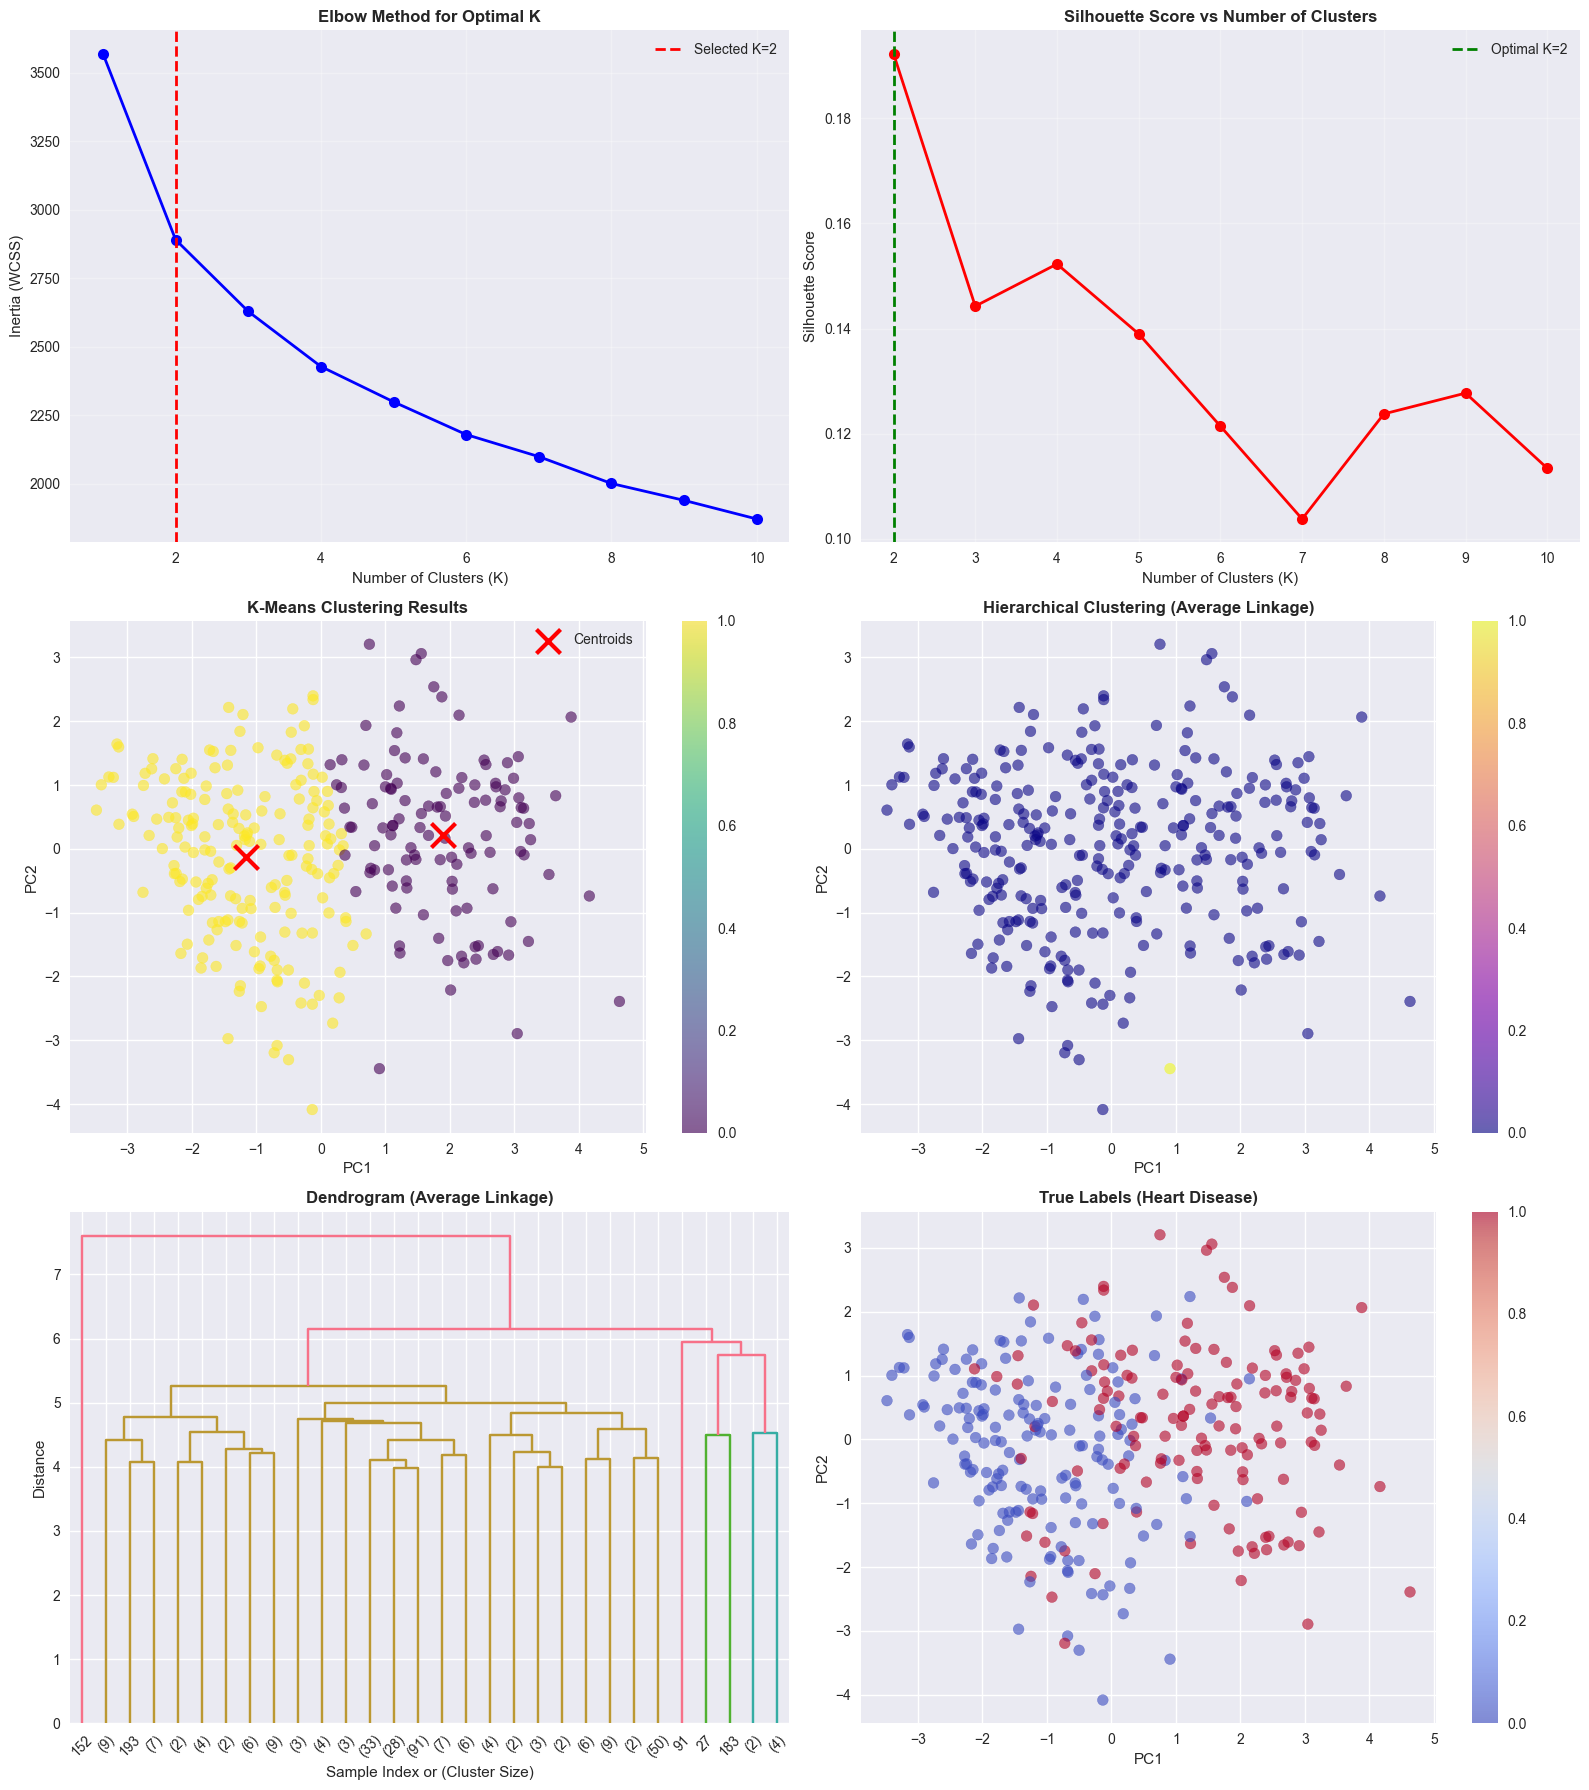

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Elbow Curve
axes[0,0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_title('Elbow Method for Optimal K', fontweight='bold')
axes[0,0].set_xlabel('Number of Clusters (K)')
axes[0,0].set_ylabel('Inertia (WCSS)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Selected K={optimal_k}')
axes[0,0].legend()

# 2. Silhouette Score vs K
K_range_sil = list(range(2, 11))
axes[0,1].plot(K_range_sil, silhouette_scores[1:], 'ro-', linewidth=2, markersize=8)
axes[0,1].set_title('Silhouette Score vs Number of Clusters', fontweight='bold')
axes[0,1].set_xlabel('Number of Clusters (K)')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axvline(x=optimal_k_silhouette, color='green', linestyle='--', 
                  linewidth=2, label=f'Optimal K={optimal_k_silhouette}')
axes[0,1].legend()

# 3. K-Means Clustering Results (using first 2 features for visualization)
feature_1, feature_2 = X_selected.columns[0], X_selected.columns[1]
scatter = axes[1,0].scatter(X_selected[feature_1], X_selected[feature_2], 
                           c=cluster_labels, cmap='viridis', alpha=0.6, s=60)
axes[1,0].scatter(kmeans_optimal.cluster_centers_[:, 0], 
                 kmeans_optimal.cluster_centers_[:, 1], 
                 c='red', marker='x', s=300, linewidths=3, label='Centroids')
axes[1,0].set_title('K-Means Clustering Results', fontweight='bold')
axes[1,0].set_xlabel(feature_1)
axes[1,0].set_ylabel(feature_2)
axes[1,0].legend()
plt.colorbar(scatter, ax=axes[1,0])

# 4. Hierarchical Clustering Results (best method)
best_hier_labels = best_hier_result['labels']
scatter2 = axes[1,1].scatter(X_selected[feature_1], X_selected[feature_2], 
                            c=best_hier_labels, cmap='plasma', alpha=0.6, s=60)
axes[1,1].set_title(f'Hierarchical Clustering ({best_hier_method.title()} Linkage)', fontweight='bold')
axes[1,1].set_xlabel(feature_1)
axes[1,1].set_ylabel(feature_2)
plt.colorbar(scatter2, ax=axes[1,1])

# 5. Dendrogram (truncated for better visualization)
dendrogram(best_hier_result['linkage_matrix'], 
          truncate_mode='lastp', p=30, 
          ax=axes[2,0], orientation='top')
axes[2,0].set_title(f'Dendrogram ({best_hier_method.title()} Linkage)', fontweight='bold')
axes[2,0].set_xlabel('Sample Index or (Cluster Size)')
axes[2,0].set_ylabel('Distance')

# 6. Comparison with True Labels
scatter3 = axes[2,1].scatter(X_selected[feature_1], X_selected[feature_2], 
                            c=y, cmap='coolwarm', alpha=0.6, s=60)
axes[2,1].set_title('True Labels (Heart Disease)', fontweight='bold')
axes[2,1].set_xlabel(feature_1)
axes[2,1].set_ylabel(feature_2)
plt.colorbar(scatter3, ax=axes[2,1])

plt.tight_layout()
plt.show()


# ===============================
# 6. CLUSTER ANALYSIS AND PROFILING
# ===============================

In [12]:
# Create DataFrame with cluster assignments
cluster_analysis_df = X_selected.copy()
cluster_analysis_df['KMeans_Cluster'] = cluster_labels
cluster_analysis_df['Hierarchical_Cluster'] = best_hier_labels
cluster_analysis_df['True_Label'] = y

# K-Means Cluster Profiling
print(" K-Means Cluster Profiling:")
print("-" * 30)
for cluster_id in range(optimal_k):
    cluster_data = cluster_analysis_df[cluster_analysis_df['KMeans_Cluster'] == cluster_id]
    print(f"\n Cluster {cluster_id}:")
    print(f"   Size: {len(cluster_data)} samples ({len(cluster_data)/len(cluster_analysis_df)*100:.1f}%)")
    
    # Heart disease distribution in this cluster
    heart_disease_dist = cluster_data['True_Label'].value_counts()
    print(f"   Heart Disease Distribution: {heart_disease_dist.to_dict()}")
    
    # Feature means for this cluster
    cluster_means = cluster_data[X_selected.columns].mean()
    print(f"   Top 3 distinguishing features:")
    
    # Compare with overall means to find distinguishing features
    overall_means = X_selected.mean()
    feature_diffs = abs(cluster_means - overall_means).sort_values(ascending=False)
    
    for i, (feature, diff) in enumerate(feature_diffs.head(3).items()):
        cluster_mean = cluster_means[feature]
        overall_mean = overall_means[feature]
        direction = "higher" if cluster_mean > overall_mean else "lower"
        print(f"      • {feature}: {cluster_mean:.3f} ({direction} than avg: {overall_mean:.3f})")

# Hierarchical Cluster Profiling
print(f"\n Hierarchical Cluster Profiling ({best_hier_method.title()} Linkage):")
print("-" * 50)
for cluster_id in range(2):
    cluster_data = cluster_analysis_df[cluster_analysis_df['Hierarchical_Cluster'] == cluster_id]
    print(f"\n Cluster {cluster_id}:")
    print(f"   Size: {len(cluster_data)} samples ({len(cluster_data)/len(cluster_analysis_df)*100:.1f}%)")
    
    # Heart disease distribution
    heart_disease_dist = cluster_data['True_Label'].value_counts()
    print(f"   Heart Disease Distribution: {heart_disease_dist.to_dict()}")

 K-Means Cluster Profiling:
------------------------------

 Cluster 0:
   Size: 115 samples (38.0%)
   Heart Disease Distribution: {1: 102, 0: 13}
   Top 3 distinguishing features:
      • PC1: 1.890 (higher than avg: -0.000)
      • PC2: 0.217 (higher than avg: 0.000)
      • PC4: -0.163 (lower than avg: -0.000)

 Cluster 1:
   Size: 188 samples (62.0%)
   Heart Disease Distribution: {0: 151, 1: 37}
   Top 3 distinguishing features:
      • PC1: -1.156 (lower than avg: -0.000)
      • PC2: -0.132 (lower than avg: 0.000)
      • PC4: 0.100 (higher than avg: -0.000)

 Hierarchical Cluster Profiling (Average Linkage):
--------------------------------------------------

 Cluster 0:
   Size: 302 samples (99.7%)
   Heart Disease Distribution: {0: 163, 1: 139}

 Cluster 1:
   Size: 1 samples (0.3%)
   Heart Disease Distribution: {0: 1}


# ===============================
# 7. CLUSTERING METHODS COMPARISON
# ===============================

In [14]:
# Compare clustering methods
comparison_results = []

# K-Means results
comparison_results.append({
    'Method': 'K-Means',
    'Silhouette_Score': silhouette_avg,
    'Calinski_Harabasz_Score': calinski_score,
    'Adjusted_Rand_Index': ari_score,
    'N_Clusters': optimal_k
})

# Hierarchical results
for method, results in hierarchical_results.items():
    comparison_results.append({
        'Method': f'Hierarchical ({method})',
        'Silhouette_Score': results['silhouette'],
        'Calinski_Harabasz_Score': results['calinski'],
        'Adjusted_Rand_Index': results['ari'],
        'N_Clusters': 2
    })

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_results)
print(" Clustering Methods Comparison:")
print(comparison_df.round(4))

# Find best overall method
best_method_idx = comparison_df['Silhouette_Score'].idxmax()
best_method = comparison_df.loc[best_method_idx, 'Method']
print(f"\n Best clustering method: {best_method}")
print(f" Best Silhouette Score: {comparison_df.loc[best_method_idx, 'Silhouette_Score']:.4f}")

 Clustering Methods Comparison:
                    Method  Silhouette_Score  Calinski_Harabasz_Score  \
0                  K-Means            0.1923                  70.6027   
1      Hierarchical (ward)            0.1567                  53.1146   
2  Hierarchical (complete)            0.1784                  13.1731   
3   Hierarchical (average)            0.3736                   3.9978   
4    Hierarchical (single)            0.3736                   3.9978   

   Adjusted_Rand_Index  N_Clusters  
0               0.4469           2  
1               0.2202           2  
2               0.0179           2  
3              -0.0010           2  
4              -0.0010           2  

 Best clustering method: Hierarchical (average)
 Best Silhouette Score: 0.3736


# ===============================
# 8. CLUSTER VALIDATION
# ===============================

 K-Means Clusters vs True Labels:
num      0    1  All
row_0               
0       13  102  115
1      151   37  188
All    164  139  303

 Hierarchical Clusters vs True Labels (average):
num      0    1  All
row_0               
0      163  139  302
1        1    0    1
All    164  139  303

 Cluster Purity Scores:
   K-Means Purity: 0.8350
   Hierarchical Purity (average): 0.5413


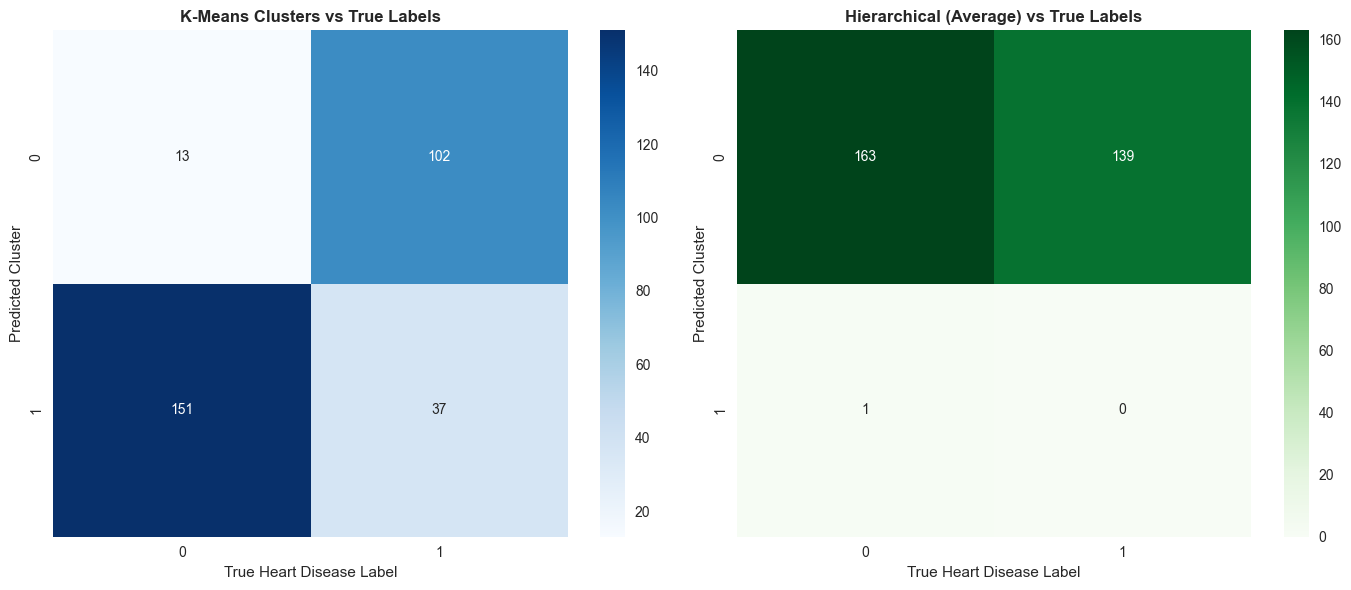

In [15]:
# Cross-tabulation between clusters and true labels
print(" K-Means Clusters vs True Labels:")
kmeans_crosstab = pd.crosstab(cluster_labels, y, margins=True)
print(kmeans_crosstab)

print(f"\n Hierarchical Clusters vs True Labels ({best_hier_method}):")
hier_crosstab = pd.crosstab(best_hier_labels, y, margins=True)
print(hier_crosstab)

# Calculate cluster purity
def calculate_purity(labels_true, labels_pred):
    """Calculate cluster purity"""
    contingency_matrix = pd.crosstab(labels_pred, labels_true)
    return np.sum(np.amax(contingency_matrix.values, axis=1)) / np.sum(contingency_matrix.values)

kmeans_purity = calculate_purity(y, cluster_labels)
hier_purity = calculate_purity(y, best_hier_labels)

print(f"\n Cluster Purity Scores:")
print(f"   K-Means Purity: {kmeans_purity:.4f}")
print(f"   Hierarchical Purity ({best_hier_method}): {hier_purity:.4f}")

# Visualize cross-tabulation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means cross-tabulation heatmap
sns.heatmap(kmeans_crosstab.iloc[:-1, :-1], annot=True, fmt='d', 
            cmap='Blues', ax=axes[0])
axes[0].set_title('K-Means Clusters vs True Labels', fontweight='bold')
axes[0].set_ylabel('Predicted Cluster')
axes[0].set_xlabel('True Heart Disease Label')

# Hierarchical cross-tabulation heatmap
sns.heatmap(hier_crosstab.iloc[:-1, :-1], annot=True, fmt='d', 
            cmap='Greens', ax=axes[1])
axes[1].set_title(f'Hierarchical ({best_hier_method.title()}) vs True Labels', fontweight='bold')
axes[1].set_ylabel('Predicted Cluster')
axes[1].set_xlabel('True Heart Disease Label')

plt.tight_layout()
plt.show()


# ===============================
# 9. SAVE CLUSTERING RESULTS
# ===============================

In [17]:
# Save K-Means model
joblib.dump(kmeans_optimal, '../Models/kmeans_model.pkl')
print(f" Saved K-Means model to '../Models/kmeans_model.pkl'")

# Save cluster assignments
cluster_assignments_df = pd.DataFrame({
    'KMeans_Cluster': cluster_labels,
    'Hierarchical_Cluster': best_hier_labels,
    'True_Label': y
})
cluster_assignments_df.to_csv('../Data/cluster_assignments.csv', index=False)
print(f" Saved cluster assignments to '../Data/cluster_assignments.csv'")

# Save clustering analysis results
clustering_results = {
    'kmeans': {
        'optimal_k': int(optimal_k),
        'silhouette_score': float(silhouette_avg),
        'calinski_harabasz_score': float(calinski_score),
        'adjusted_rand_index': float(ari_score),
        'cluster_distribution': cluster_distribution,
        'purity': float(kmeans_purity)
    },
    'hierarchical': {
        'best_method': best_hier_method,
        'silhouette_score': float(best_hier_result['silhouette']),
        'calinski_harabasz_score': float(best_hier_result['calinski']),
        'adjusted_rand_index': float(best_hier_result['ari']),
        'purity': float(hier_purity)
    },
    'elbow_analysis': {
        'K_range': list(K_range),
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'calinski_scores': calinski_scores
    },
    'comparison_results': comparison_df.to_dict('records'),
    'best_overall_method': best_method
}

import json

# # Save as JSON
# with open('../Results/clustering_analysis.json', 'w') as f:
#     json.dump(clustering_results, f, indent=4)

# Save as text summary
with open('../Results/clustering_summary.txt', 'w') as f:
    f.write("HEART DISEASE DATASET - UNSUPERVISED LEARNING SUMMARY\n")
    f.write("=" * 60 + "\n")
    f.write(f"Dataset: {X_selected.shape[0]} samples, {X_selected.shape[1]} features\n")
    f.write(f"Selected features: {list(X_selected.columns)}\n\n")
    
    f.write("K-MEANS CLUSTERING RESULTS:\n")
    f.write("-" * 30 + "\n")
    f.write(f"Optimal K: {optimal_k}\n")
    f.write(f"Silhouette Score: {silhouette_avg:.4f}\n")
    f.write(f"Calinski-Harabasz Score: {calinski_score:.4f}\n")
    f.write(f"Adjusted Rand Index: {ari_score:.4f}\n")
    f.write(f"Cluster Purity: {kmeans_purity:.4f}\n")
    f.write(f"Cluster Distribution: {cluster_distribution}\n\n")
    
    f.write("HIERARCHICAL CLUSTERING RESULTS:\n")
    f.write("-" * 35 + "\n")
    f.write(f"Best Linkage Method: {best_hier_method}\n")
    f.write(f"Silhouette Score: {best_hier_result['silhouette']:.4f}\n")
    f.write(f"Calinski-Harabasz Score: {best_hier_result['calinski']:.4f}\n")
    f.write(f"Adjusted Rand Index: {best_hier_result['ari']:.4f}\n")
    f.write(f"Cluster Purity: {hier_purity:.4f}\n\n")
    
    f.write("OVERALL COMPARISON:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Best Overall Method: {best_method}\n")
    f.write("\nAll Methods Comparison:\n")
    for _, row in comparison_df.iterrows():
        f.write(f"  {row['Method']}: Silhouette={row['Silhouette_Score']:.4f}, "
               f"ARI={row['Adjusted_Rand_Index']:.4f}\n")

print(f" Saved clustering results to 'results/clustering_analysis.json'")
print(f" Saved clustering summary to 'results/clustering_summary.txt'")


 Saved K-Means model to '../Models/kmeans_model.pkl'
 Saved cluster assignments to '../Data/cluster_assignments.csv'
 Saved clustering results to 'results/clustering_analysis.json'
 Saved clustering summary to 'results/clustering_summary.txt'
